# Lab 1 Solution - Linear Regression Basics

Erez Buchweitz

# Implement ordinary least squares

1.  Generate a matrix $\boldsymbol{X}$ and an array $\boldsymbol{Y}$
    filled with random values using the Python package `numpy`.

In [101]:
import numpy as np

n = 10000
p = 100
X = np.random.normal(size=(n, p))
Y = np.random.normal(size=n)

1.  Implement the calculation of the OLS estimator using `numpy`.

In [102]:
def fit_OLS(X, Y):
    return np.linalg.inv(X.T @ X) @ (X.T @ Y)

1.  What is the time complexity of your implementation?

Please read about time complexity in computer science. Time complexity
measures how the running time of your code depends on the input
parameters, in this case $N$ and $P$. We count basic operations that the
computer needs to perform. Let us break `fit_OLS` down component by
component:

|  |  |  |  |
|------------------|---------------|------------|----------------------------|
| `X.T` | matrix transpose | $\mathcal{O}(NP)$ | need to visit each of the $NP$ cells of the matrix $\boldsymbol{X}$ |
| `X.T @ X` | matrix multiplication | $\mathcal{O}(NP^2)$ | the matrix $\boldsymbol{X}^T\boldsymbol{X}$ has $P^2$ cells, the value of each is a sum of $N$ elements |
| `(X.T @ X)^{-1}` | matrix inversion | $\mathcal{O}(P^3)$ | `numpy` implements an $\mathcal{O}(P^3)$ algorithm to invert a $P\times P$ matrix, I think |
| `X.T @ Y` | matrix multiplication | $\mathcal{O}(NP)$ | the vector $\boldsymbol{X}^T\boldsymbol{Y}$ has $P$ cells, the value of each is a sum of $N$ elements |
| `(X.T @ X)^{-1} @ (X.T @ Y)` | matrix multiplication | $\mathcal{O}(P^2)$ | the vector has $P$ cells, the value of each is a sum of $P$ elements |

The total complexity is
$\mathcal{O}(NP + NP^2 + P^3)=\mathcal{O}(NP^2)$. The $\mathcal{O}$
notation hides any constants and considers only the asymptotically
dominating factor $\mathcal{O}(NP^2)$, which comes from the computation
of the matrix product $\boldsymbol{X}^T\boldsymbol{X}$. The reason this
factor dominates the others is that $P\leq N$, which follows from the
assumption that $\boldsymbol{X}$ has full column rank. If $P>N$ then the
OLS estimator is undefined.

1.  Is there a difference between implementing it like
    $((\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T)\boldsymbol{Y}$
    and like
    $(\boldsymbol{X}^T\boldsymbol{X})^{-1}(\boldsymbol{X}^T\boldsymbol{Y})$?
    Why?

The former includes the computation of the matrix product of
$(\boldsymbol{X}^T\boldsymbol{X})^{-1}$ with $\boldsymbol{X}^T$ which
takes $\mathcal{O}(NP^2)$ time. The asymptotic complexity is the same
for both implementations (both $\mathcal{O}(NP^2)$), but the former does
the heaviest matrix multiplication twice, so asymptotically we can
expect the latter to run twice faster.

In [103]:
import timeit

print(timeit.timeit("np.linalg.inv(X.T @ X) @ (X.T @ Y)", number=500, globals=globals()))
print(timeit.timeit("(np.linalg.inv(X.T @ X) @ X.T) @ Y", number=500, globals=globals()))

2.821722199994838
6.396999699994922

1.  Calculate the OLS estimator again over the same data, this time
    using the Python package `sklearn`.

In [104]:
import sklearn.linear_model

mdl = sklearn.linear_model.LinearRegression(fit_intercept=False)
mdl.fit(X, Y)

LinearRegression(fit_intercept=False) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. LinearRegression ? Documentation for LinearRegression i Fitted LinearRegression(fit_intercept=False)

1.  Compare the predictions generated by your implementation with those
    of `sklearn`, they should be identical.

They code below shows that they are identical up to machine error. Those
of you who didn’t notice that `sklearn` has the default parameter
`fit_intercept=True` got very different predictions. The lesson is that
when using a library function you have to be very careful in making sure
it does exactly what you want it to do.

In [105]:
b = fit_OLS(X, Y)
pred_my = X @ b
pred_sklearn = mdl.predict(X)

np.max(np.abs(pred_my - pred_sklearn))

1.0269562977782698e-15

# Implement a loss function

1.  Implement a function that computes the average squared error between
    two vectors $\boldsymbol{Y}$ and $\hat{\boldsymbol{Y}}$, element by
    element:
    -   In a vectorized way using `numpy`.
    -   Using a for loop, list comprehension or in another
        non-vectorized way.

In [106]:
def squared_error(y, yhat):
    return np.mean(np.subtract(y, yhat) ** 2)

def squared_error_non_vectorized(y, yhat):
    n = len(y)
    error = 0
    for i in range(n):
        error += (y[i] - yhat[i]) ** 2
    return error / n

1.  Compare the execution time of the two implementations, using
    `timeit`.

In [107]:
print(timeit.timeit("squared_error(Y, Y)", number=1000, globals=globals()))
print(timeit.timeit("squared_error_non_vectorized(Y, Y)", number=1000, globals=globals()))

0.025690200011013076
4.079844299994875

1.  Why is there a difference in execution time between the two
    implementations?

Please read about this.

# Train and test data

1.  Split the rows of $(\boldsymbol{X},\boldsymbol{Y})$ into two sets,
    call them train and test.

We’ll split the rows randomly into half train half test.

In [108]:
def split(X, Y, train_fraction):
    """
    train_fraction - fraction of total data to be assigned to train
    """
    n = X.shape[0]
    n_train = int(X.shape[0] * train_fraction) # train set size
    idx_train = np.random.choice(n, replace=False, size=n_train) # indices of rows to be assigned to train
    idx_test = np.setdiff1d(list(range(n)), idx_train) # indices of rows to be assigned to test
    X_train = X[idx_train, :]
    Y_train = Y[idx_train]
    X_test = X[idx_test, :]
    Y_test = Y[idx_test]
    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = split(X, Y, train_fraction=0.5)

1.  Fit OLS on the train set, and compute the average squared error of
    the OLS prediction:
    -   On the train set.
    -   On the test set.

In [109]:
b = fit_OLS(X_train, Y_train)
error_train = squared_error(Y_train, X_train @ b)
error_test = squared_error(Y_test, X_test @ b)
error_train, error_test

(1.0094912216216076, 1.0518340521358611)

1.  Is there a difference between the two errors? If so, why?

The test error is larger but the difference is small.

1.  How does the size of the train set affect the two errors?

Let’s compute. We’ll partition our data randomly into train and test
sets multiple times, each time the train set will encompass a different
fraction of the total data. For every fraction, we’ll average the train
and the test losses over 50 random partitions.

In [110]:
def compare_train_test_error(X, Y, num_iterations):
    """
    num_iterations - number of repetitions of random partitioning into train and test to be averaged over
    """
    train_fraction = [i/100 for i in range(5, 90)] # fraction of train out of total data
    error_train = []
    error_test = []
    for frac in train_fraction:
        cur_error_train = []
        cur_error_test = []
        for _ in range(num_iterations): # for every fraction, average over <num_iterations> partitions
            X_train, Y_train, X_test, Y_test = split(X, Y, frac)
            b = fit_OLS(X_train, Y_train)
            cur_error_train.append(squared_error(Y_train, X_train @ b))
            cur_error_test.append(squared_error(Y_test, X_test @ b))
        error_train.append(np.mean(cur_error_train))
        error_test.append(np.mean(cur_error_test))
    return train_fraction, error_train, error_test

Now we plot the results. Conclusions from the plots:

-   The train error is on average smaller than the test error. Our
    objective is to minimize test error, because this is the error on
    observations that the model has not been trained on. This means that
    train error is not a good proxy for test error - it is too
    optimistic.
-   Test error decreases as the size of the trainin set grows. The more
    observations to train on - the better.
-   The gap between train and test error decreases as the size of the
    train set grows. The train error becomes more realistic the larget
    the train set is, but never quite meets the test error.

Note that if the test set is too small, the test error will be noisy. So
the test set should not be too small.

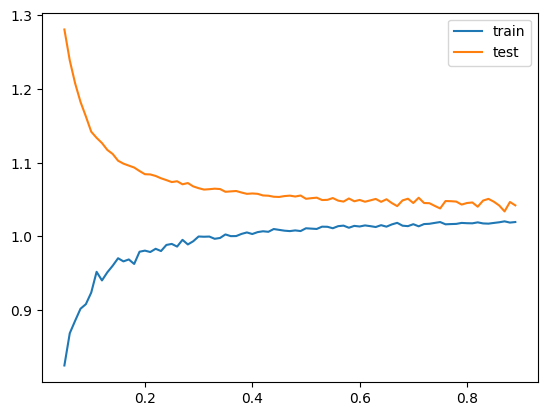

In [111]:

from matplotlib import pyplot as plt

train_fraction, error_train, error_test = compare_train_test_error(X, Y, num_iterations=50)

plt.plot(train_fraction, error_train, label="train")
plt.plot(train_fraction, error_test, label="test")
plt.legend()
plt.show()

# Feature engineering

1.  Linear with intercept:
    $\hat y= \beta_0 + \boldsymbol{x}^T\boldsymbol{\beta}$.

Denoting the coordinates of $x$ by $x_1,\dots,x_P$, $$
\varphi:\mathbb{R}^P\to\mathbb{R}^{P+1}, \; \; \; \; \varphi(x) = (1,x_1,\dots,x_{P}).
$$ We add a column of $1$’s to $\boldsymbol{X}$.

1.  Quadratic: $\hat y= \boldsymbol{x}^T \boldsymbol{B}\boldsymbol{x}$
    where $\boldsymbol{B}$ is a $P\times P$ matrix.

$$
\varphi:\mathbb{R}^P\to\mathbb{R}^{P(P+1)/2}, \; \; \; \; \varphi(x)=\{x_ix_j\}_{1\leq i \leq j \leq P}.
$$

1.  Step function with cutoffs at known values, over a single feature.

Suppose we want $\hat{y}$ to be constant when $x\leq c$, and possibly
another constant when $x>c$. Then: $$
\varphi:\mathbb{R}\to\{0,1\}^2, \; \; \; \; \varphi(x)=(I(x\leq c), I(x>c)),
$$ where $I(A)$ is in the indicator function assuming value $1$ when the
event $A$ materializes and $0$ otherwise.

We replace $\boldsymbol{X}$ with a one-hot column for each step.

1.  Continuous piece-wise linear function, over a single feature.

Suppose we want $\hat{y}$ to be affine (linear plus constant) when
$x\leq c$, and affine with possibly another slope when $x>c$. We also
want to constrain that the two affine functions have the same value when
$x=c$, so that $\hat{y}$ as a function of $x$ will be continuous. Then:
$$
\varphi:\mathbb{R}\to\mathbb{R}^3, \; \; \; \;  \varphi(x)=(1, xI(x\leq c), (x-c)I(x>c)).
$$

1.  Is it possible to implement an infinite-dimensional feature mapping
    $\varphi$? That is, $Q=\infty$.

It is impossible to compute $\varphi(x)$ because it is inifinite,
however there are ways of using infinite feature mappings in linear
regression without having to directly compute $\varphi(x)$. These are
known as kernel methods.